In [19]:
import torch
import cv2
import matplotlib.pyplot as plt
import os
import random
import numpy as np

In [2]:
from albumentations import (
    CLAHE,
    Blur,
    OneOf,
    Compose,
    RGBShift,
    GaussNoise,
    RandomGamma,
    RandomContrast,
    RandomBrightness,
)
from albumentations.augmentations.transforms import Normalize
from albumentations.pytorch.transforms import ToTensorV2

/home/rahul/.conda/envs/opcv/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


In [3]:
from detector import Detector
from torch.utils.data import DataLoader
from trainer.datasets import ListDataset

In [17]:
from trainer.encoder import (
    DataEncoder,
    decode_boxes,
    encode_boxes,
    generate_anchors,
    generate_anchor_grid,
)

In [4]:
classes=[
    "__background__",
    "biker",
    "car",
    "pedestrian",
    "trafficLight",
    "trafficLight-Green",
    "trafficLight-GreenLeft",
    "trafficLight-Red",
    "trafficLight-RedLeft",
    "trafficLight-Yellow",
    "trafficLight-YellowLeft",
    "truck"
]

In [5]:
dataset_test = ListDataset(
    root_dir="../../../Datasets/Road_Scene_Object_Detection",
    data_dir = 'export',
    list_file='annots_transformed_test.txt',
    classes=[
        "__background__",
        "biker",
        "car",
        "pedestrian",
        "trafficLight",
        "trafficLight-Green",
        "trafficLight-GreenLeft",
        "trafficLight-Red",
        "trafficLight-RedLeft",
        "trafficLight-Yellow",
        "trafficLight-YellowLeft",
        "truck"
    ],
    mode='val',
    transform=Compose([Normalize(), ToTensorV2()]),
    input_size=300
)
loader_test = DataLoader(
    dataset=dataset_test,
    batch_size=32,
    shuffle=False,
    collate_fn=dataset_test.collate_fn,
    num_workers=5,
    pin_memory=True
)

In [6]:
index = random.randrange(len(loader_test.dataset))

In [7]:
image, gt_boxes, _ = loader_test.dataset[index]

In [8]:
device = torch.device("cuda")
image = image.to(device).clone()

In [9]:
model = Detector(len(classes))

In [10]:
model_path = "/media/rahul/a079ceb2-fd12-43c5-b844-a832f31d5a39/Projects/autonomous_cars/Object_Detector_for_road/SSD_Detector_for_road_training/checkpoints/Detector_best.pth"

In [12]:
model.load_state_dict(
                torch.load(model_path)
            )
model = model.eval()

In [13]:
std = (0.229, 0.224, 0.225)
mean = (0.485, 0.456, 0.406)

std = torch.Tensor(std)
mean = torch.Tensor(mean)

In [14]:
model.to(device)

Detector(
  (fpn): FPN(
    (feature_extractor): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchN

In [15]:
loc_preds, cls_preds = model(image.unsqueeze(0))

In [16]:
cls_preds, loc_preds

(tensor([[[ 18.2573,  -0.1787,  -1.3797,  ...,  -3.2775,  -3.3234,  -2.6274],
          [ 18.2873,  -1.5227,  -0.6517,  ...,  -2.3808,  -4.3708,  -7.2128],
          [ 18.8527,  -1.1245,  -0.3172,  ...,  -2.4669,  -1.9267,  -3.4808],
          ...,
          [ -3.8866,  -1.7218,  53.1161,  ...,  -3.3886,   4.8897,  10.3400],
          [ 20.3438,  -3.0455,  36.8962,  ...,   1.6826, -13.1623,   5.2545],
          [ 47.4293,  -1.5095,  -0.4408,  ...,  -8.3299,  -4.4942,  -3.1430]]],
        device='cuda:0', grad_fn=<CatBackward>),
 tensor([[[-0.0432, -0.0291, -0.2275,  0.0508],
          [-0.0681,  0.0541, -0.3648, -0.0085],
          [-0.0674, -0.1260, -0.4379,  0.1779],
          ...,
          [ 0.0659,  0.0082, -0.1544, -0.2305],
          [ 0.0667, -0.3118, -0.1478,  0.3537],
          [ 0.0631, -0.4516, -0.0806,  0.5474]]], device='cuda:0',
        grad_fn=<CatBackward>))

In [31]:
with torch.no_grad():
    img = image.cpu()
    img.mul_(std[:, None, None]).add_(mean[:, None, None])
    img = torch.clamp(img, min=0.0, max=1.0)
    img = img.numpy().transpose(1, 2, 0)

    img = (img * 255.).astype(np.uint8)
    gt_img = img.copy()
    pred_img = img.copy()

    for box in gt_boxes:
        gt_img = cv2.rectangle(
            gt_img, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), (255, 0, 0),
            thickness=2
        )

    encoder = DataEncoder((img.shape[1], img.shape[0]))
    samples = encoder.decode(loc_preds, cls_preds)
    c_dets = samples[0][3]  # detections for class == 2

    if c_dets.size > 0:
        boxes = c_dets[:, :4]
        for box in boxes:
            pred_img = cv2.rectangle(
                pred_img, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), (0, 0, 255),
                thickness=2
            )

In [37]:
samples[0][7]

array([], shape=(0, 5), dtype=float32)

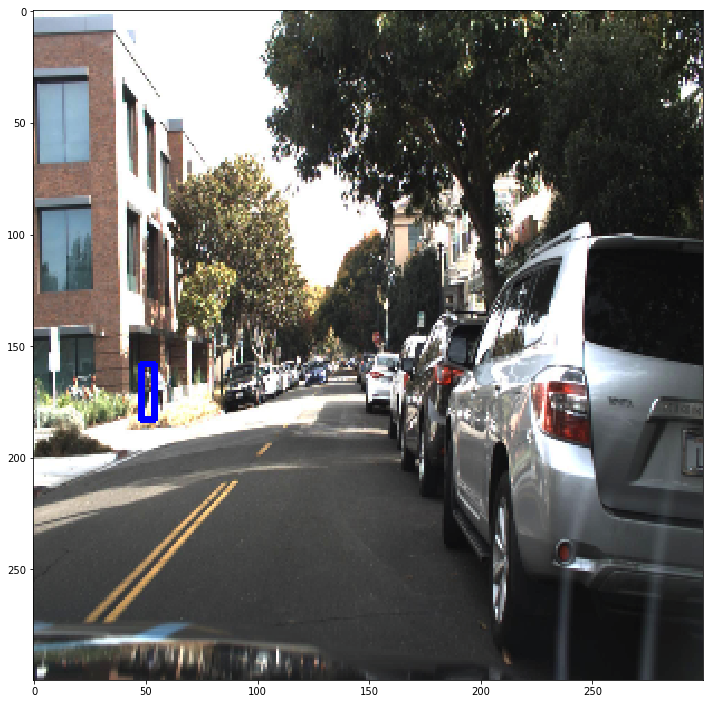

In [33]:
plt.figure(figsize = (12,18))
plt.imshow(pred_img)
plt.show()